In [28]:
import sys
sys.path.insert(0, "../")
sys.path.insert(0, "../experiments")


from experiment_information import *
from experiment_setup import *
from data import *
from helpers import *
from data_loading import *
import matplotlib.pyplot as plt



import pandas as pd
import numpy as np
import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)


import numpy as np
import re
%load_ext autoreload
%autoreload 2



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


This code assumes that you have defined and run an experiment before using `define_experiment.ipynb` in the `experiments` folder.

In [29]:
df_experiments, df_state_evolution, df_erm = obtain_dataframes(logger)
df_experiments.head(5)

Current code version, 113
Current code version, 113


,experiment_id,experiment_name,duration,problem_types,code_version,date,state_evolution_repetitions,erm_repetitions,alphas,epsilons,...,taus,ps,dp,d,experiment_type,completed,data_model_types,data_model_names,data_model_descriptions,gamma_fair_error
35,b5fc72ce-96e4-4cde-a7a0-af14597e4d8c,FeatureComparisonsTestOneSubspace,526.851988,"[""Logistic""]",113,2024-06-19 15:25:53,1,10,"[0.1585, 0.2226, 0.3128, 0.4394, 0.6173, 0.867...","[0.0, 0.1, 0.2, 0.3]",...,[0.05],null,0.01,500,Sweep,1,"[""KFeaturesModel"", ""KFeaturesModel"", ""KFeature...","[""KFeaturesModel_TwoFeatures_ProtectingSecondS...","[""2 Features, Theta Identity, Sigma_upsilon Id...",0.0001
36,563ecf6b-fb6e-4f7d-8307-7fa5ee1dfc46,EquivalentSweep,113.162089,"[""Logistic""]",113,2024-06-19 15:23:29,1,10,"[0.1585, 0.2154, 0.2929, 0.3981, 0.5412, 0.735...","[0.0, 0.1, 0.2, 0.3]",...,[0.05],null,0.01,500,Sweep,1,"[""KFeaturesModel""]","[""KFeaturesModel_TwoFeatures_ProtectingSecondS...","[""2 Features, Theta Identity, Sigma_upsilon Id...",0.0001
34,c81f4dad-a905-4552-ad63-0c94af0503f9,EquivalentSweep,135.530188,"[""Logistic""]",113,2024-06-19 14:47:32,1,10,"[0.1585, 0.2308, 0.336, 0.4892, 0.7122, 1.037,...","[0.0, 0.1, 0.2, 0.3]",...,[0.05],null,0.01,500,Sweep,1,"[""KFeaturesModel""]","[""KFeaturesModel_TwoFeatures_ProtectingSecondS...","[""2 Features, Theta Identity, Sigma_upsilon Id...",0.0001
33,ed1bfdad-23b3-4929-9601-7126e6fea410,SweepAtOptimalLambda,47.452392,"[""Logistic""]",113,2024-06-19 11:51:05,1,10,"[4.0, 4.0526, 4.1053, 4.1579, 4.2105, 4.2632, ...","[0.0, 0.1, 0.2, 0.3]",...,[0.05],null,0.01,500,SweepAtOptimalLambda,1,"[""KFeaturesModel""]","[""KFeaturesModel_TwoFeatures_ProtectingSecondS...","[""2 Features, Theta Identity, Sigma_upsilon Id...",0.0001
31,f2ad5999-006a-489c-88e4-f924985ee46c,FeatureComparisonsTestOneSubspace,417.302198,"[""Logistic""]",113,2024-06-17 12:07:56,1,10,"[0.1585, 0.2154, 0.2929, 0.3981, 0.5412, 0.735...","[0.0, 0.1, 0.2, 0.3]",...,[0.05],null,0.01,500,Sweep,1,"[""KFeaturesModel"", ""KFeaturesModel"", ""KFeature...","[""KFeaturesModel_TwoFeatures_ProtectingSecondS...","[""2 Features, Theta Identity, Sigma_upsilon Id...",0.0001


In [30]:
experiment_loc = 1

# extract experiment by id "250fa46e-55cb-40d2-b503-11b38823235d"
# experiment_id = "d43ae27a-cf92-4261-a7d1-de5c9717f775"


# extract and print the top experiment_id
experiment_id = df_experiments.iloc[experiment_loc]["experiment_id"]
print(experiment_id)

# extract and print the experiment type
experiment_type = df_experiments.iloc[experiment_loc]["experiment_type"]
print(experiment_type)

# extract and print the data model type and data_model name used
data_model_types = df_experiments.iloc[experiment_loc]["data_model_types"]
# convert it to the enum
data_model_types = [DataModelType[data_model_type] for data_model_type in json.loads(data_model_types)]
data_model_names = [name for name in json.loads(df_experiments.iloc[experiment_loc]["data_model_names"])]
data_model_descriptions = df_experiments.iloc[experiment_loc]["data_model_descriptions"]
for data_model_type in data_model_types:
    print(data_model_type.name)
print(data_model_names)
print(data_model_descriptions)

# print the experiment name
experiment_name = df_experiments.iloc[experiment_loc]["experiment_name"]
print(experiment_name)

# print the experiment problem types
experiment_problem_types = df_experiments.iloc[experiment_loc]["problem_types"]
experiment_problem_types = json.loads(experiment_problem_types)
print(experiment_problem_types)

563ecf6b-fb6e-4f7d-8307-7fa5ee1dfc46
Sweep
KFeaturesModel
['KFeaturesModel_TwoFeatures_ProtectingSecondStronger_AttackingIdentity_[0.5 0.5]_[1 1]_[1 1]_SD_1_1_SU_1_1___EquivalentSweep']
["2 Features, Theta Identity, Sigma_upsilon Identity, Sigma_delta Identity"]
EquivalentSweep
['Logistic']


In [31]:
data_model_name_dict = {}
data_model_name_dict["VanillaGaussian"] = "Vanilla Gaussian"
data_model_name_dict["2_VanillaGaussian"] = "Vanilla Gaussian"
data_model_name_dict["VanillaGaussianThetaFirst"] = "Vanilla Gaussian - Teacher 10:1"
data_model_name_dict["VanillaGaussianTimes10"] = "Vanilla Gaussian x10"
data_model_name_dict["KFeaturesModel_TwoFeatures_ProtectingIdentity_AttackingIdentity_[0.5 0.5]_[10  1]_[1 1]"] = "Strong Weak 10:1"
data_model_name_dict["KFeaturesModel_TwoFeatures_ProtectingIdentity_AttackingIdentity_[0.5 0.5]_[5 1]_[1 1]"] = "Strong Weak 5:1"
data_model_name_dict["2_KFeaturesModel_TwoFeatures_ProtectingIdentity_AttackingIdentity_[0.5 0.5]_[5 1]_[1 1]"] = "Strong Weak 5:1"
data_model_name_dict["2_KFeaturesModel_TwoFeatures_ProtectingIdentity_AttackingIdentity_[0.5 0.5]_[10  1]_[1 1]"] = "Strong Weak 10:1"
data_model_name_dict["KFeaturesModel_TwoFeatures_ProtectingIdentity_AttackingIdentity_[0.5 0.5]_[5 1]_[10  1]"] = "Strong Weak 5:1 - Teacher 10:1"
data_model_name_dict["KFeaturesModel_TwoFeatures_ProtectingIdentity_AttackingIdentity_[0.5 0.5]_[10  1]_[10  1]"] = "Strong Weak 10:1 - Teacher 10:1"
data_model_name_dict["KFeaturesModel_TwoFeatures_ProtectingIdentity_AttackingIdentity_[0.5 0.5]_[5 1]_[ 1 10]"] = "Strong Weak 5:1 - Teacher 1:10"
data_model_name_dict["KFeaturesModel_TwoFeatures_ProtectingIdentity_AttackingIdentity_[0.5 0.5]_[10  1]_[ 1 10]"] = "Strong Weak 10:1 - Teacher 1:10"


In [32]:
state_evolution = df_state_evolution[df_state_evolution["experiment_id" ] == experiment_id]
gd = df_erm[df_erm["experiment_id" ] == experiment_id]
# make the column subspace_overlaps to string
state_evolution["subspace_overlaps"] = state_evolution["subspace_overlaps"].apply(lambda x: str(x))
gd["subspace_overlaps"] = gd["subspace_overlaps"].apply(lambda x: str(x))

# create a json colum
state_evolution["subspace_overlaps"] = state_evolution["subspace_overlaps"].apply(lambda x: json.loads(x))
gd["subspace_overlaps"] = gd["subspace_overlaps"].apply(lambda x: json.loads(x))
from pandas import json_normalize
# normalize the json column
normalized = json_normalize(state_evolution["subspace_overlaps"])
normalized_gd = json_normalize(gd["subspace_overlaps"])



def explode_array_column(row, col):
    return pd.Series(row[col])

# reset the index of the original dataframe
state_evolution = state_evolution.reset_index(drop=True)
gd = gd.reset_index(drop=True)

for col in normalized.columns:
    expanded_cols = normalized.apply(lambda x: explode_array_column(x,col), axis=1)
    col = col[:-1]
    expanded_cols.columns = [col+'_{}'.format(i) for i in range(expanded_cols.shape[1])]
    # reset the index of the expanded columns
    expanded_cols = expanded_cols.reset_index(drop=True)
    state_evolution = pd.concat([state_evolution, expanded_cols], axis=1)

for col in normalized_gd.columns:
    expanded_cols = normalized_gd.apply(lambda x: explode_array_column(x,col), axis=1)
    col = col[:-1]
    expanded_cols.columns = [col+'_{}'.format(i) for i in range(expanded_cols.shape[1])]
    # reset the index of the expanded columns
    expanded_cols = expanded_cols.reset_index(drop=True)

    gd = pd.concat([gd, expanded_cols], axis=1)



/var/folders/vl/6t_sjl4j16nd3xx4b0t7wd280000gn/T/ipykernel_22899/3541688095.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  state_evolution["subspace_overlaps"] = state_evolution["subspace_overlaps"].apply(lambda x: str(x))
/var/folders/vl/6t_sjl4j16nd3xx4b0t7wd280000gn/T/ipykernel_22899/3541688095.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gd["subspace_overlaps"] = gd["subspace_overlaps"].apply(lambda x: str(x))
/var/folders/vl/6t_sjl4j16nd3xx4b0t7wd280000gn/T/ipykernel_22899/3541688095.py:8: 

In [33]:
state_evolution["subspace_overlaps_ratio"] = state_evolution["subspace_overlaps_ratio"].apply(lambda x: str(x))
state_evolution["subspace_overlaps_ratio"] = state_evolution["subspace_overlaps_ratio"].apply(lambda x: json.loads(x))
normalized = json_normalize(state_evolution["subspace_overlaps_ratio"])
# rename the columns of the normalized dataframe
for column in normalized.columns:
    normalized = normalized.rename(columns={column:column+"_ratio"})
# merge the normalized dataframe with the original dataframe
state_evolution = pd.concat([state_evolution, normalized], axis=1)
# drop the original subspace_overlaps column
state_evolution = state_evolution.drop(columns=["subspace_overlaps_ratio"])

gd["subspace_overlaps_ratio"] = gd["subspace_overlaps_ratio"].apply(lambda x: str(x))
gd["subspace_overlaps_ratio"] = gd["subspace_overlaps_ratio"].apply(lambda x: json.loads(x))
normalized = json_normalize(gd["subspace_overlaps_ratio"])
# rename the columns of the normalized dataframe
for column in normalized.columns:
    normalized = normalized.rename(columns={column:column+"_ratio"})
# merge the normalized dataframe with the original dataframe
gd = pd.concat([gd, normalized], axis=1)
# drop the original subspace_overlaps column
gd = gd.drop(columns=["subspace_overlaps_ratio"])


In [34]:
# create a column for the difference between the adversarial_generalization_error and the generalization_error for both the state evolution and the erm
state_evolution["difference_adv_gen"] = state_evolution["adversarial_generalization_error"] - state_evolution["generalization_error"]
gd["difference_adv_gen"] = gd["adversarial_generalization_error"] - gd["generalization_error_erm"]


state_evolution["ratio_adv_gen"] = state_evolution["adversarial_generalization_error"] / state_evolution["generalization_error"]
gd["ratio_adv_gen"] = gd["adversarial_generalization_error"] / gd["generalization_error_erm"]

In [35]:
# create a column for the noise contribution
def noise_contribution(rho: float, tau: float) -> float:
    if tau == 0:
        tau = 1e-10
    return 0.5 - np.arctan( np.sqrt( rho / tau**2 ) ) / np.pi

state_evolution["noise_contribution"] = state_evolution.apply(lambda x: noise_contribution(x["rho"], x["tau"]), axis=1)
gd["noise_contribution"] = gd.apply(lambda x: noise_contribution(x["rho"], x["tau"]), axis=1)

In [36]:
# create a column for the noiseless generalization error without the noise contribution
state_evolution["noiseless_generalization_error"] = state_evolution["generalization_error"] - state_evolution["noise_contribution"]
gd["noiseless_generalization_error_erm"] = gd["generalization_error_erm"] - gd["noise_contribution"]

# create a column for the adversarial noiseless generalization error without the noise contribution
state_evolution["noiseless_adversarial_generalization_error"] = state_evolution["adversarial_generalization_error"] - state_evolution["noise_contribution"]
gd["noiseless_adversarial_generalization_error"] = gd["adversarial_generalization_error"] - gd["noise_contribution"]

In [37]:
# create a column for the A/sqrt(q*N) for both the state evolution and the erm
state_evolution["A_over_sqrt_qN"] = state_evolution["A"] / np.sqrt(state_evolution["q"] * state_evolution["N"])
gd["A_over_sqrt_qN"] = gd["A"] / np.sqrt(gd["q"] * gd["N"])

In [38]:
# create a column for m/sqrt( rho*q - m**2 ) vs A/sqrt(q*N) for both the state evolution and the erm
state_evolution["m_over_sqrt_rhoq_minus_m2"] = state_evolution["m"] / np.sqrt(state_evolution["rho"] * state_evolution["q"] - state_evolution["m"]**2)
gd["m_over_sqrt_rhoq_minus_m2"] = gd["m"] / np.sqrt(gd["rho"] * gd["q"] - gd["m"]**2)


In [39]:
# strip the data_model_name if there is a sequence ___text at the end
def strip_data_model_name(data_model_name):
    return re.sub(r"___.*","",data_model_name)
state_evolution["data_model_name"] = state_evolution["data_model_name"].apply(strip_data_model_name)
gd["data_model_name"] = gd["data_model_name"].apply(strip_data_model_name)

In [40]:
gd = gd.set_index(["alpha","epsilon","tau","lam","problem_type","attack_epsilon","data_model_name"]) #,"p_calibration"
state_evolution = state_evolution.set_index(["alpha","epsilon","tau","lam","problem_type","attack_epsilon","data_model_name"]) #,"p_calibration"

# drop id, code_version, experiment_id, date, initial_condition, test_against_epsilons, calibrations, abs_tol, min_iter,max_iter,blend_fpe,int_lims,subspace_overlaps
state_evolution = state_evolution.drop(columns=["id","code_version","experiment_id","date","initial_condition","test_against_epsilons","calibrations","abs_tol","min_iter","max_iter","blend_fpe","int_lims","subspace_overlaps","data_model_type","data_model_description"])
# drop id, code_version, experiment_id, test_against_epsilons, date, subspace_overlaps, analytical_calibrations, erm_calibrations, 
gd = gd.drop(columns=["id","code_version","experiment_id","test_against_epsilons","date","subspace_overlaps","analytical_calibrations","erm_calibrations","data_model_type","data_model_description"])

state_evolution.columns = [col+"_state_evolution" for col in state_evolution.columns]
gd.columns = [col+"_erm" for col in gd.columns]

state_evolution = state_evolution.groupby(level=[0,1,2,3,4,5,6]).agg(["mean","std"]) #,4
gd = gd.groupby(level=[0,1,2,3,4,5,6]).agg(["mean","std"]) #,4
df = state_evolution.join(gd, how="outer")
df.sort_index()
df

index_state_evolution  \
                                                                                                                           mean   
alpha    epsilon tau  lam  problem_type attack_epsilon data_model_name                                                            
0.1585   0.0     0.05 0.01 Logistic     0.1            KFeaturesModel_TwoFeatures_ProtectingSecondStro...               61752.0   
         0.1     0.05 0.01 Logistic     0.1            KFeaturesModel_TwoFeatures_ProtectingSecondStro...               61754.0   
         0.2     0.05 0.01 Logistic     0.1            KFeaturesModel_TwoFeatures_ProtectingSecondStro...               61757.0   
         0.3     0.05 0.01 Logistic     0.1            KFeaturesModel_TwoFeatures_ProtectingSecondStro...               61760.0   
0.2154   0.0     0.05 0.01 Logistic     0.1            KFeaturesModel_TwoFeatures_ProtectingSecondStro...               61756.0   
...                                                                                                                         ...   
73.5642  0.3     0.05 0.01 Logistic     0.1            KFeaturesModel_TwoFeatures_ProtectingSecondStro...               61883.0   
100.0000 0.0     0.05 0.01 Logistic     0.1            KFeaturesModel_TwoFeatures_ProtectingSecondStro...               61884.0   
         0.1     0.05 0.01 Logistic     0.1            KFeaturesModel_TwoFeatures_ProtectingSecondStro...               61886.0   
         0.2     0.05 0.01 Logistic     0.1            KFeaturesModel_TwoFeatures_ProtectingSecondStro...               61887.0   
         0.3     0.05 0.01 Logistic     0.1            KFeaturesModel_TwoFeatures_ProtectingSecondStro...               61889.0   

                                                                                                               \
                                                                                                          std   
alpha    epsilon tau  lam  problem_type attack_epsilon data_model_name                                          
0.1585   0.0     0.05 0.01 Logistic     0.1            KFeaturesModel_TwoFeatures_ProtectingSecondStro... NaN   
         0.1     0.05 0.01 Logistic     0.1            KFeaturesModel_TwoFeatures_ProtectingSecondStro... NaN   
         0.2     0.05 0.01 Logistic     0.1            KFeaturesModel_TwoFeatures_ProtectingSecondStro... NaN   
         0.3     0.05 0.01 Logistic     0.1            KFeaturesModel_TwoFeatures_ProtectingSecondStro... NaN   
0.2154   0.0     0.05 0.01 Logistic     0.1            KFeaturesModel_TwoFeatures_ProtectingSecondStro... NaN   
...                                                                                                        ..   
73.5642  0.3     0.05 0.01 Logistic     0.1            KFeaturesModel_TwoFeatures_ProtectingSecondStro... NaN   
100.0000 0.0     0.05 0.01 Logistic     0.1            KFeaturesModel_TwoFeatures_ProtectingSecondStro... NaN   
         0.1     0.05 0.01 Logistic     0.1            KFeaturesModel_TwoFeatures_ProtectingSecondStro... NaN   
         0.2     0.05 0.01 Logistic     0.1            KFeaturesModel_TwoFeatures_ProtectingSecondStro... NaN   
         0.3     0.05 0.01 Logistic     0.1            KFeaturesModel_TwoFeatures_ProtectingSecondStro... NaN   

                                                                                                          duration_state_evolution  \
                                                                                                                              mean   
alpha    epsilon tau  lam  problem_type attack_epsilon data_model_name                                                               
0.1585   0.0     0.05 0.01 Logistic     0.1            KFeaturesModel_TwoFeatures_ProtectingSecondStro...                 1.088816   
         0.1     0.05 0.01 Logistic     0.1            KFeaturesModel_TwoFeatures_ProtectingSecondStro...                 1.090657   
         0.2     0

In [41]:
# store the dataframe as a pickle file
if not os.path.exists("Pickles"):
    os.makedirs("Pickles")
if not os.path.exists("Pickles/effective_regularisation.pkl"):
    df.to_pickle("Pickles/effective_regularisation.pkl")

In [42]:
# load the data
df = pd.read_pickle("Pickles/effective_regularisation.pkl")

# extracting the data

In [43]:
# get unique epsilons
epsilons = df.index.get_level_values(1).unique()
epsilons

Index([0.0, 0.1, 0.2, 0.3], dtype='float64', name='epsilon')

In [44]:
# get unique attack_epsilons
attack_epsilons = df.index.get_level_values(5).unique()
attack_epsilons

Index([0.1], dtype='float64', name='attack_epsilon')

In [45]:
# create a dictionary of dataframes for each data_model_name
epsilon_dict = {}
for epsilon in epsilons:

    eps_df = df.xs(epsilon, level="epsilon")
    

    alphas = eps_df.index.get_level_values("alpha").unique()
    adversarial_error_0 = eps_df["adversarial_generalization_error_state_evolution"]["mean"].values
    generalization_error_0 = eps_df["generalization_error_state_evolution"]["mean"].values
    boundary_error_0 = eps_df["difference_adv_gen_state_evolution"]["mean"].values
    class_preserving = eps_df["fair_adversarial_error_state_evolution"]["mean"].values

    adversarial_error_erm = eps_df["adversarial_generalization_error_erm"]["mean"].values
    generalization_error_erm = eps_df["generalization_error_erm_erm"]["mean"].values
    boundary_error_erm = eps_df["difference_adv_gen_erm"]["mean"].values
    class_preserving_erm = eps_df["fair_adversarial_error_erm"]["mean"].values

    adversarial_error_erm_std = eps_df["adversarial_generalization_error_erm"]["std"].values
    generalization_error_erm_std = eps_df["generalization_error_erm_erm"]["std"].values
    boundary_error_erm_std = eps_df["difference_adv_gen_erm"]["std"].values
    class_preserving_erm_std = eps_df["fair_adversarial_error_erm"]["std"].values


    alphas = np.array(alphas)
    adversarial_error_0 = np.array(adversarial_error_0)
    generalization_error_0 = np.array(generalization_error_0)
    boundary_error_0 = np.array(boundary_error_0)
    class_preserving = np.array(class_preserving)


    adversarial_error_erm = np.array(adversarial_error_erm)
    generalization_error_erm = np.array(generalization_error_erm)
    boundary_error_erm = np.array(boundary_error_erm)
    class_preserving_erm = np.array(class_preserving_erm)

    adversarial_error_erm_std = np.array(adversarial_error_erm_std)
    generalization_error_erm_std = np.array(generalization_error_erm_std)
    boundary_error_erm_std = np.array(boundary_error_erm_std)
    class_preserving_erm_std = np.array(class_preserving_erm_std)


    eps_0_dict = {}
    eps_0_dict["alphas"] = alphas
    eps_0_dict["adversarial_error"] = adversarial_error_0
    eps_0_dict["generalization_error"] = generalization_error_0
    eps_0_dict["boundary_error"] = boundary_error_0
    eps_0_dict["class_preserving"] = class_preserving

    eps_0_dict["adversarial_error_erm"] = adversarial_error_erm
    eps_0_dict["generalization_error_erm"] = generalization_error_erm
    eps_0_dict["boundary_error_erm"] = boundary_error_erm
    eps_0_dict["class_preserving_erm"] = class_preserving_erm

    eps_0_dict["adversarial_error_erm_std"] = adversarial_error_erm_std
    eps_0_dict["generalization_error_erm_std"] = generalization_error_erm_std
    eps_0_dict["boundary_error_erm_std"] = boundary_error_erm_std
    eps_0_dict["class_preserving_erm_std"] = class_preserving_erm_std



    epsilon_dict[epsilon] = eps_0_dict


# Figure saving

Figure size:  (2.5, 2.4)
Figure size:  [2.5 2.4]


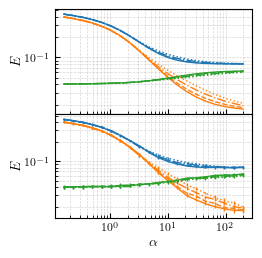

<Figure size 640x480 with 0 Axes>

In [46]:

IMG_DIRECTORY = "./Assets/effective_regularisation"
if not os.path.exists(IMG_DIRECTORY):
    os.makedirs(IMG_DIRECTORY)


def save_plot(fig, name, formats=["pdf","jpg"], date=False):
    current_date = datetime.datetime.now().strftime("%Y-%m-%d")
    for f in formats:        
        path = "{}".format(name) + "_{}".format(current_date) + "." + f
        if not date:
            path = "{}".format(name) + "." + f
        fig.savefig(            
            os.path.join(IMG_DIRECTORY, path),
            format=f,
        )


def set_size(width, fraction=1, subplots=(1, 1)):
    if width == "thesis":
        width_pt = 426.79135
    elif width == "beamer":
        width_pt = 307.28987
    else:
        width_pt = width

    fig_width_pt = width_pt * fraction
    inches_per_pt = 1 / 72.27

    golden_ratio = (5**0.5 - 1) / 2

    fig_width_in = fig_width_pt * inches_per_pt
    fig_height_in = fig_width_in * (golden_ratio) * (subplots[0] / subplots[1])

    return (fig_width_in, fig_height_in)


width = 1.75 * 458.63788

multiplier = 1.25
width = multiplier * 234.8775

plt.style.use("../latex_ready.mplstyle")

tuple_size = set_size(width, fraction=0.50)
tuple_size = ( 2.5 , 2.4 )

fig, axs = plt.subplots(
    nrows=2,
    ncols=1,
    sharex=True,
    figsize=( tuple_size[0], tuple_size[1]),
    gridspec_kw={"hspace": 0},
)

# print the figure size
print("Figure size: ", tuple_size)
# print the figure size
print("Figure size: ", fig.get_size_inches())

from matplotlib.pyplot import Line2D

# ICML adjustments
fig.subplots_adjust(left=0.2)
fig.subplots_adjust(bottom=0.12)
fig.subplots_adjust(top=0.99)
fig.subplots_adjust(right=0.99)




linestyles = ["solid", "dashed", "dashdot", "dotted"]

for idx, (epsilon, eps_dict) in enumerate(epsilon_dict.items()):


    alphas = eps_dict["alphas"]
    adversarial_error = eps_dict["adversarial_error"]
    generalization_error = eps_dict["generalization_error"]
    boundary_error = eps_dict["boundary_error"]
    class_preserving = eps_dict["class_preserving"]

    adversarial_error_erm = eps_dict["adversarial_error_erm"]
    generalization_error_erm = eps_dict["generalization_error_erm"]
    boundary_error_erm = eps_dict["boundary_error_erm"]
    class_preserving_erm = eps_dict["class_preserving_erm"]

    adversarial_error_erm_std = eps_dict["adversarial_error_erm_std"]
    generalization_error_erm_std = eps_dict["generalization_error_erm_std"]
    boundary_error_erm_std = eps_dict["boundary_error_erm_std"]
    class_preserving_erm_std = eps_dict["class_preserving_erm_std"]


    axs[0].plot(alphas, adversarial_error,  color="C0", linestyle=linestyles[idx])
    axs[0].plot(alphas, generalization_error, color="C1", linestyle=linestyles[idx])
    axs[0].plot(alphas, boundary_error,  color="C2", linestyle=linestyles[idx])
    # axs[0].plot(alphas, class_preserving,  color="C3", linestyle=linestyles[idx])



    # axs[1].plot(
    #     alphas,
    #     adversarial_error_erm,        
    #     linestyle=linestyles[idx],
    #     color="C0"
    # )
    # axs[1].plot(
    #     alphas,
    #     generalization_error_erm, 
    #     linestyle=linestyles[idx],
    #     color="C1"
    # )
    # axs[1].plot(
    #     alphas,
    #     boundary_error_erm,        
    #     linestyle=linestyles[idx],
    #     color="C2"
    # )


    axs[1].errorbar(
        alphas,
        adversarial_error_erm,
        yerr=adversarial_error_erm_std,
        
        markersize=1,
        linestyle=linestyles[idx],
        color="C0"
    )
    axs[1].errorbar(
        alphas,
        generalization_error_erm,
        yerr=generalization_error_erm_std,
        markersize=1,
        linestyle=linestyles[idx],
        color="C1"
    )
    axs[1].errorbar(
        alphas,
        boundary_error_erm,
        yerr=boundary_error_erm_std,
        
        markersize=1,
        linestyle=linestyles[idx],
        color="C2"
    )
    # axs[1].errorbar(
    #     alphas,
    #     class_preserving_erm,
    #     yerr=class_preserving_erm_std,
    #     fmt="*",
    #     markersize=1,
    #     color="C3"
    # )

axs[0].set_xscale("log")
axs[0].set_yscale("log")
axs[0].set_ylabel(r"$E$", labelpad=2.0)
# axs[0].set_xlabel(r"$\alpha$", labelpad=2.0)
axs[0].grid(which="both", axis="both", alpha=0.5)
axs[0].tick_params(axis='both', which='major', direction='in')
axs[0].tick_params(axis='both', which='minor', direction='in')
# axs[0].legend(title="State Evolution", loc="lower left")

axs[1].set_xscale("log")
axs[1].set_yscale("log")
axs[1].set_ylabel(r"$E$", labelpad=2.0)
axs[1].set_xlabel(r"$\alpha$", labelpad=2.0)
axs[1].grid(which="both", axis="both", alpha=0.5)
axs[1].tick_params(axis='both', which='major', direction='in')
axs[1].tick_params(axis='both', which='minor', direction='in')
# axs[1].legend(title="$\\boldsymbol{b}$", loc="lower left")



error_legend = []

error_legend.append(Line2D([0],[0],label=r"$E_{\mathrm{adv}}$",color="C0"))
error_legend.append(Line2D([0],[0],label=r"$E_{\mathrm{gen}}$",color="C1"))
error_legend.append(Line2D([0],[0],label=r"$E_{\mathrm{bound}}$",color="C2"))
error_legend.append(Line2D([],[], color="white"))

epsilon_legend = []

for idx, epsilon in enumerate(epsilons):
    epsilon_legend.append(Line2D([0],[0],color="black", linestyle=linestyles[idx], label=r"$\varepsilon_t={}$".format(epsilons[idx]))) 

custom_legend = []

for idx in range(len(error_legend)):
    custom_legend.append(error_legend[idx])
    custom_legend.append(epsilon_legend[idx])

# fig.legend(handles=custom_legend, loc="upper center", ncol=4, handlelength=1.5)

save = True
if save:
    save_plot(
        fig,
        "effective_regularisation",
    )

plt.show()

plt.tight_layout()





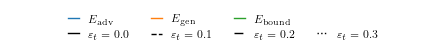

In [22]:
# save the legend separately, put the custom legend into a figure
figlegend = plt.figure(figsize=( 4.25, 0.15*tuple_size[1]))
plt.style.use("../latex_ready.mplstyle")
legend_ax = figlegend.add_axes([0, 0, 1, 1])
legend_ax.axis('off')  # Turn off the axes for the legend figure

figlegend.legend(
    handles=custom_legend,
    handlelength=1,
    loc="center",
    ncol=4,
)

figlegend.savefig(
    os.path.join(IMG_DIRECTORY, "legend.pdf"),
    format="pdf",
    # bbox_inches="tight",
)


plt.show()



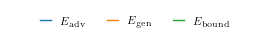

In [23]:
custom_legend = []

custom_legend.append(Line2D([0],[0],label=r"$E_{\mathrm{adv}}$",color="C0"))
custom_legend.append(Line2D([0],[0],label=r"$E_{\mathrm{gen}}$",color="C1"))
custom_legend.append(Line2D([0],[0],label=r"$E_{\mathrm{bound}}$",color="C2"))
# custom_legend.append(Line2D([0],[0],label=r"$E_{\mathrm{CP}}$",color="C0", marker='o'))





# save the legend separately, put the custom legend into a figure
figlegend = plt.figure(figsize=( tuple_size[0], 0.1 * tuple_size[0]))
plt.style.use("../latex_ready.mplstyle")
legend_ax = figlegend.add_axes([0, 0, 1, 1])
legend_ax.axis('off')  # Turn off the axes for the legend figure

figlegend.legend(
    handles=custom_legend,
    handlelength=1,
    loc="center",
    ncol=5,
)

figlegend.savefig(
    os.path.join(IMG_DIRECTORY, "effective_regularisation_legend_error.pdf"),
    format="pdf",
    # bbox_inches="tight",
)


plt.show()




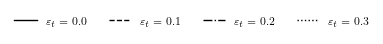

In [24]:
custom_legend = []

for idx, epsilon in enumerate(epsilons):
    custom_legend.append(Line2D([0],[0],color="black", linestyle=linestyles[idx], label=r"$\varepsilon_t={}$".format(epsilons[idx]))) 


# save the legend separately, put the custom legend into a figure
figlegend = plt.figure(figsize=( 1.2 * tuple_size[0],0.1 * tuple_size[0]))
plt.style.use("../latex_ready.mplstyle")
legend_ax = figlegend.add_axes([0, 0, 1, 1])
legend_ax.axis('off')  # Turn off the axes for the legend figure

figlegend.legend(
    handles=custom_legend,
    handlelength=2,
    loc="center",
    ncol=5,
)

figlegend.savefig(
    os.path.join(IMG_DIRECTORY, "effective_regularisation_legend_epsilon.pdf"),
    format="pdf",
    # bbox_inches="tight",
)


plt.show()

